In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

img_path = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_sportychic_sportychic_Base_Pose_Standing_C/imgs/0001863_shadow.png'
img = plt.imread(img_path)
plt.imshow(img)

(512, 512, 4)


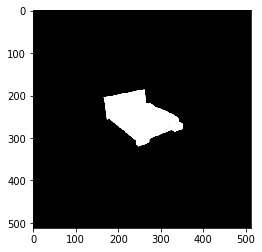

In [21]:
img = plt.imread('/home/ysheng/Dataset/soft_shadow/train/bed_0329_normalize/imgs/0000000_mask.png')

print(img.shape)

plt.figure()
plt.imshow(img[:,:,0], cmap='gray')

In [3]:
import torch
import ssn_dataset
from torchvision import transforms, utils
import numpy as np

csv_file = "~/Dataset/soft_shadow/train/metadata.csv"
# compose_transform = None
training_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = True)
testing_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = False)

print('training set size: ', len(training_dataset))
print('testing set size: ',len(testing_dataset))

print(len(training_dataset.meta_data))
print(training_dataset.meta_data[0])

# for j in range(10):
#     for i in range(len(training_dataset)):
#         data = training_dataset[i]
# #         print("{} \r".format(i), flush=True, end="")
#         print("{} ".format(i))
    
# for i,data in enumerate(testing_dataset):
#     print("{} \r".format(i), flush=True, end="")

Dataset initialize spent: 9.288192510604858 ms
Dataset initialize spent: 9.01149868965149 ms
training set size:  410573
testing set size:  41057
456192
['/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_C'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_C/imgs/0003859_mask.png'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_C/imgs/0003859_shadow.png'
 '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_C/imgs/0003859_light.png'
 '0_1.77912_1.65471' "['219.854']"
 '0.47193399068677_2.746446_1.5897799944120599']


In [4]:
keys = list(training_dataset.mappings.keys())

print(len(keys))
print(keys[0])
print(len(training_dataset.mappings[keys[0]]))

1188
('simulated_combine_female_short_outfits_audrey_blair_summertimefull_Base_Pose_Standing_C', '0_1.77912_1.65471', "['219.854']")
384


In [5]:
import sys
sys.path.append("..")
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import random

dataloader = DataLoader(training_dataset, batch_size=1, shuffle=False, num_workers=1)

mask min: 0.0, max: 1.0
light min: 0.001024047378450632, max: 0.23655493557453156
shadow min: 0.0, max: 0.26113206148147583
Before light source min: 0.001024047378450632, max: 0.23655493557453156
torch.Size([1, 1, 16, 32])
torch.Size([1, 1, 16, 32])
light source min: 0.001024047378450632, max: 0.23655493557453156
torch.Size([1, 1, 512, 512])


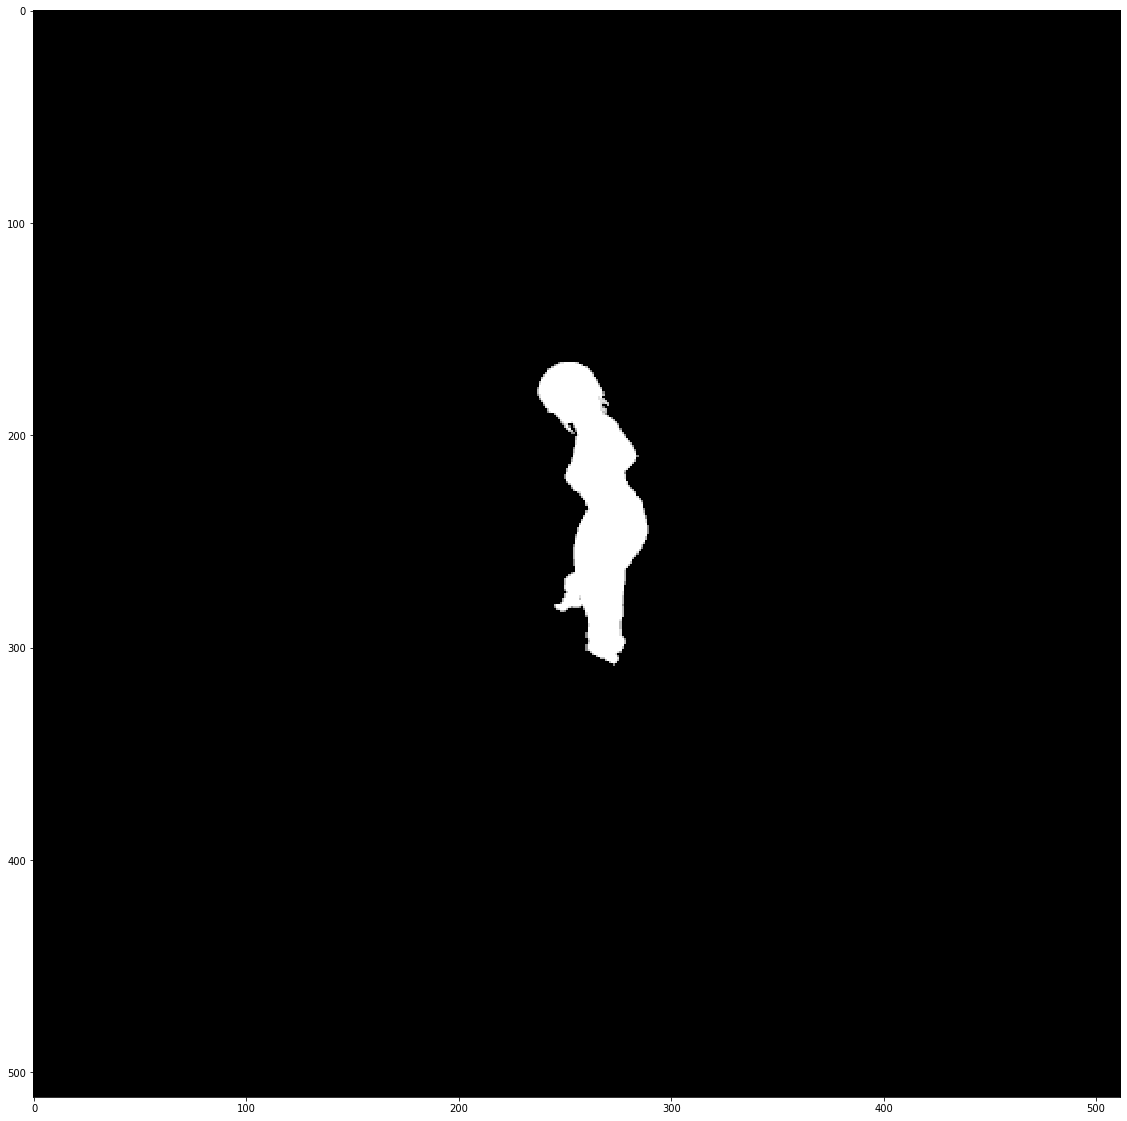

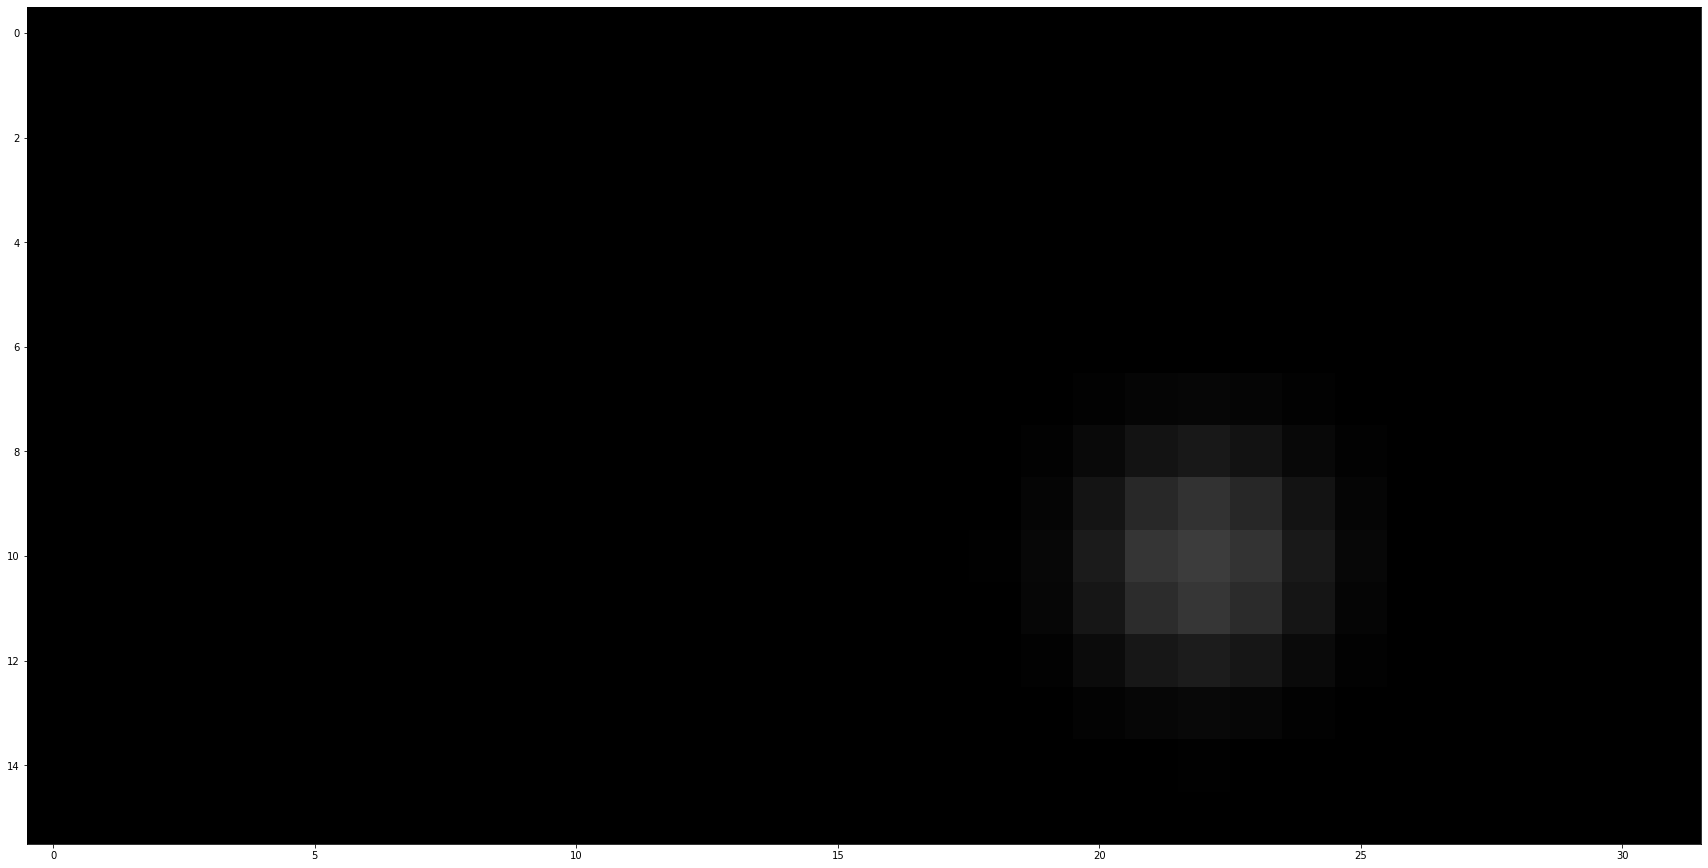

shadow min: 0.0, max: 1.0


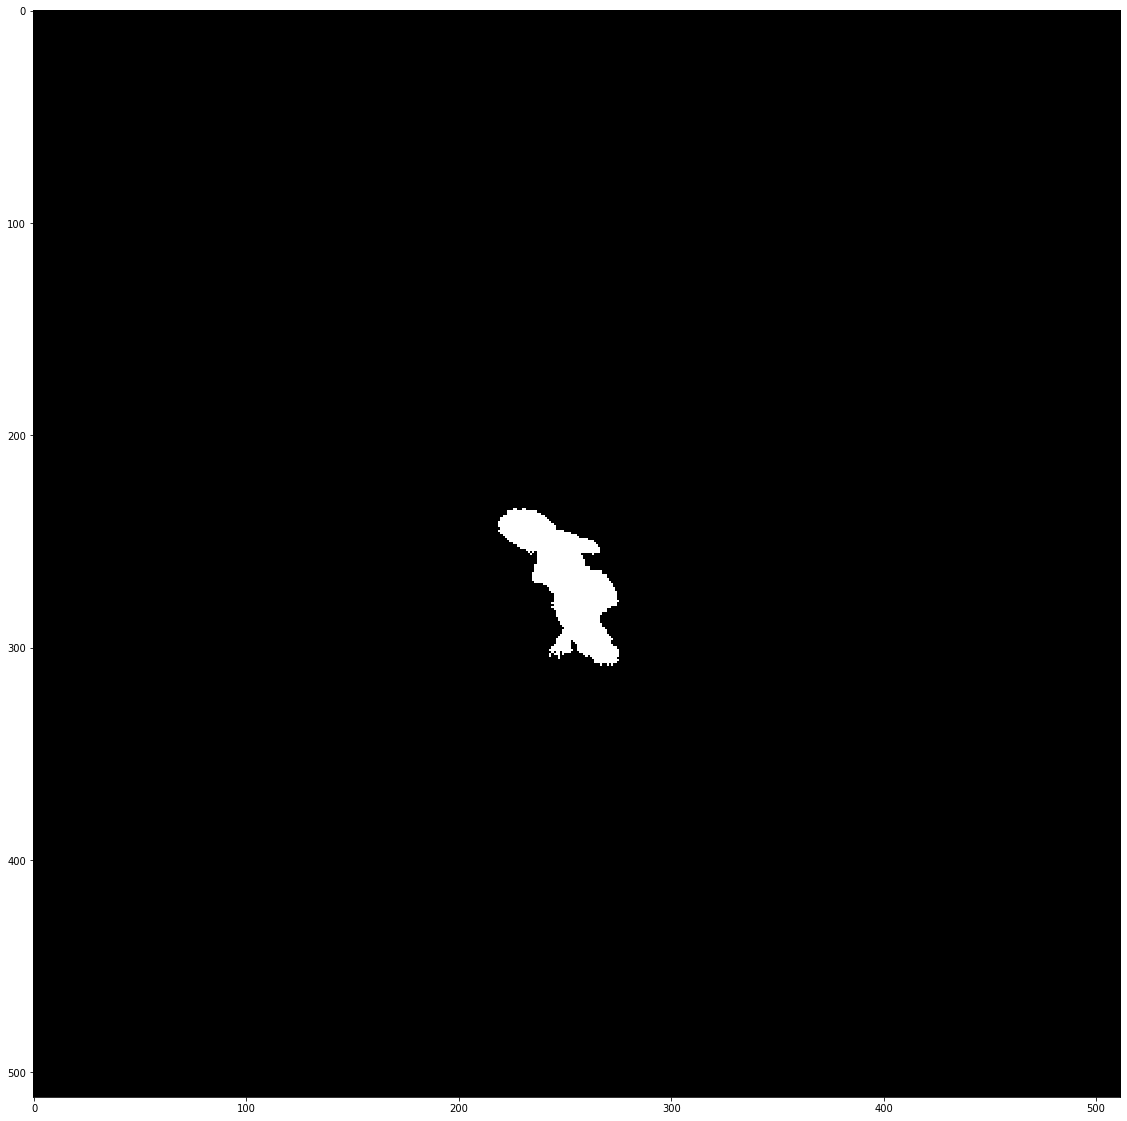

mask min: 0.0, max: 1.0
light min: 0.0021099091973155737, max: 0.4873889982700348
shadow min: 0.0, max: 0.5380268096923828
Before light source min: 0.0021099091973155737, max: 0.4873889982700348
torch.Size([1, 1, 16, 32])
torch.Size([1, 1, 16, 32])
light source min: 0.0021099091973155737, max: 0.4873889982700348
torch.Size([1, 1, 512, 512])


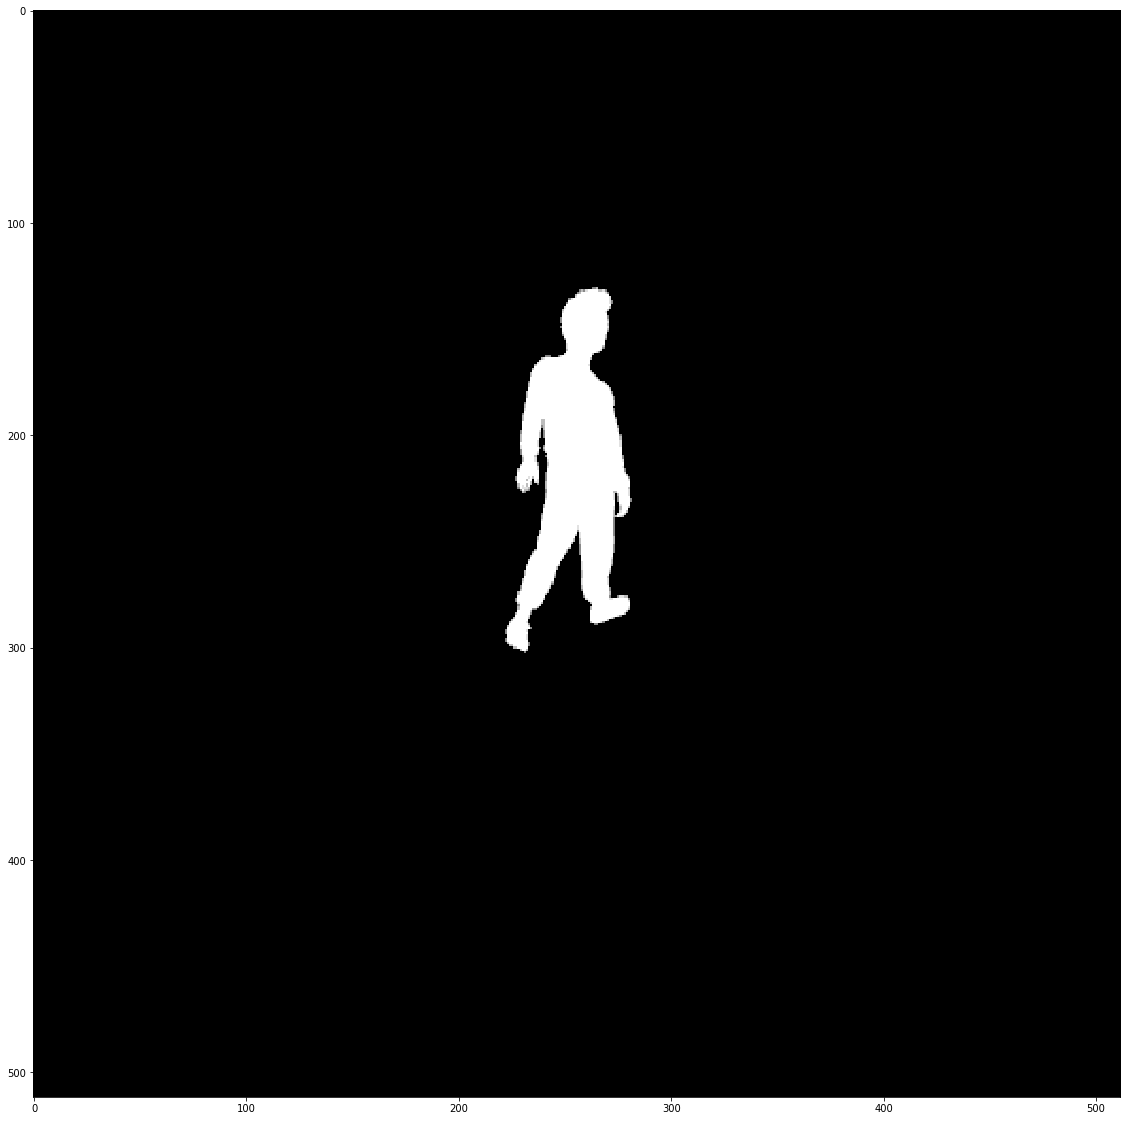

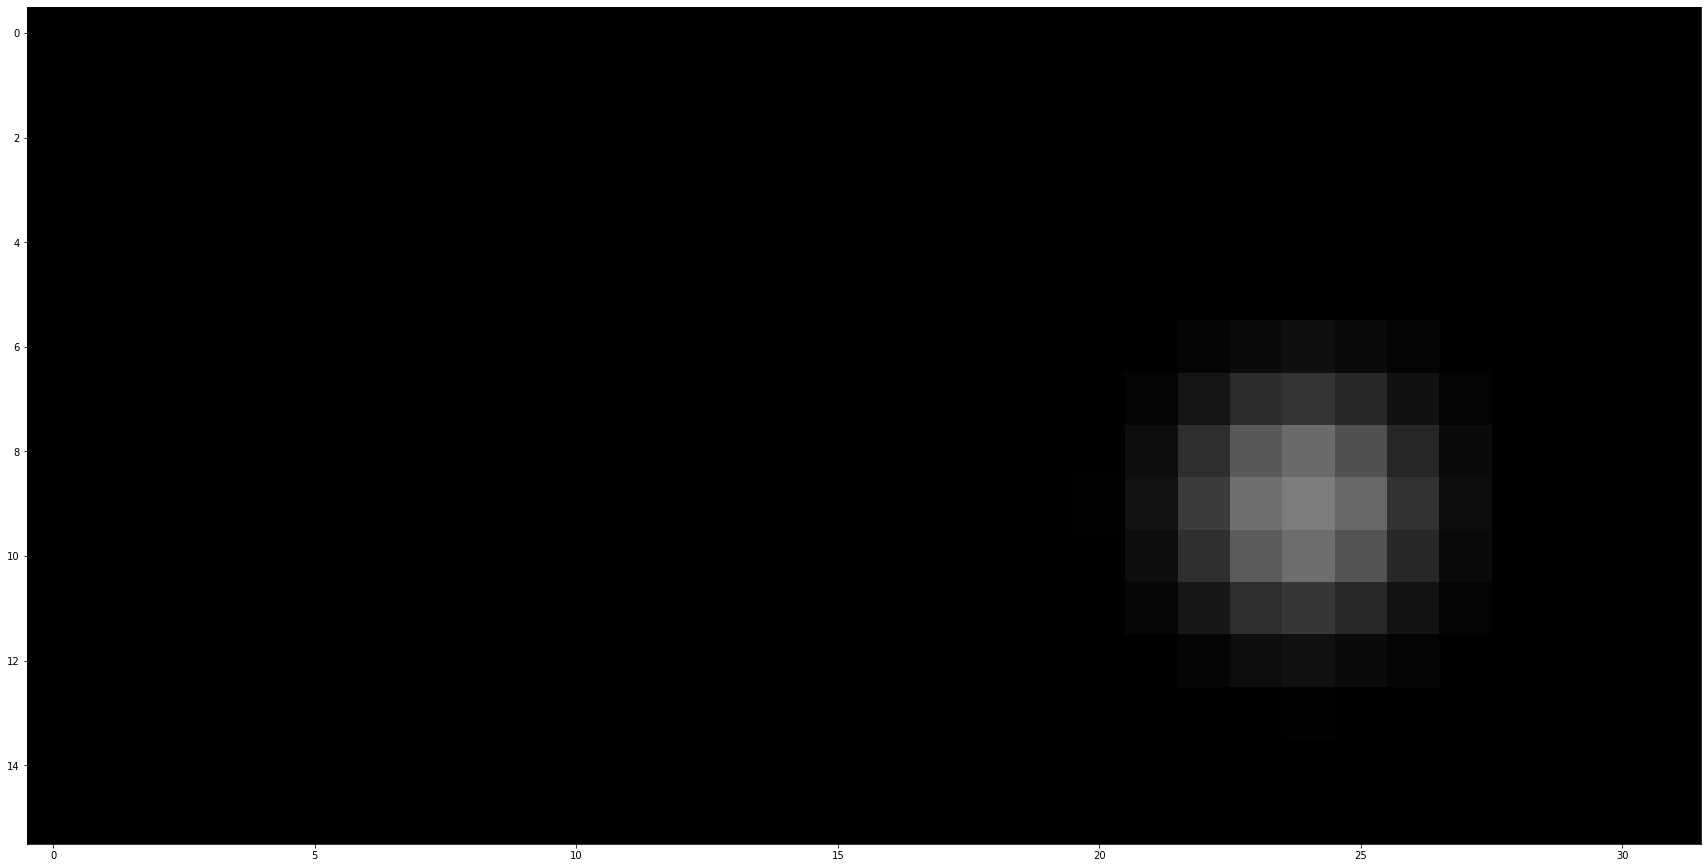

shadow min: 0.0, max: 1.0


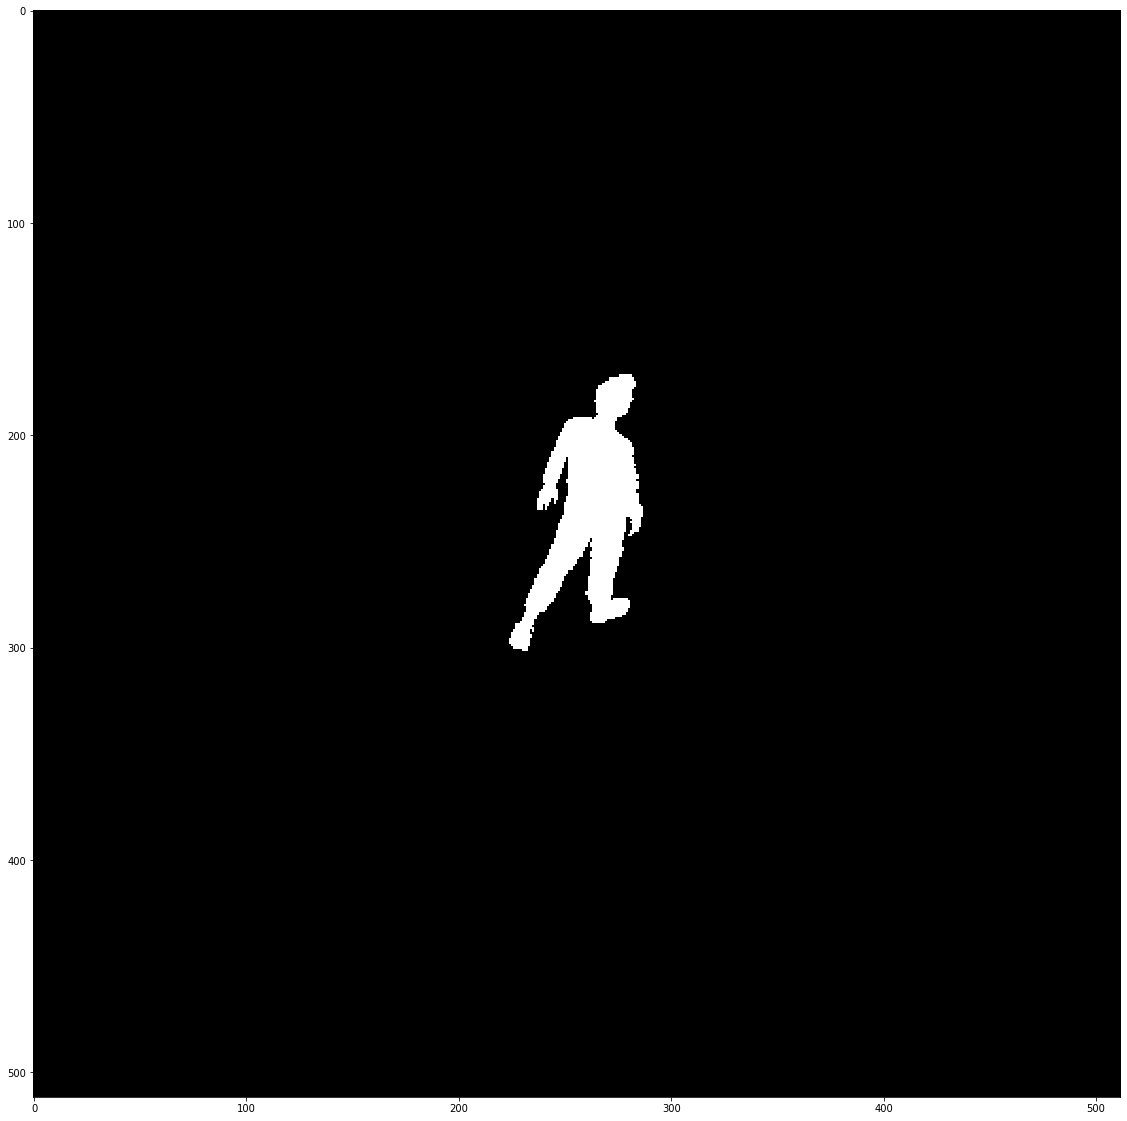

mask min: 0.0, max: 1.0
light min: 0.008914259262382984, max: 0.9485742449760437
shadow min: 0.0, max: 2.2731361389160156
Before light source min: 0.008914259262382984, max: 0.9485742449760437
torch.Size([1, 1, 16, 32])
torch.Size([1, 1, 16, 32])
light source min: 0.008914259262382984, max: 0.9485742449760437
torch.Size([1, 1, 512, 512])


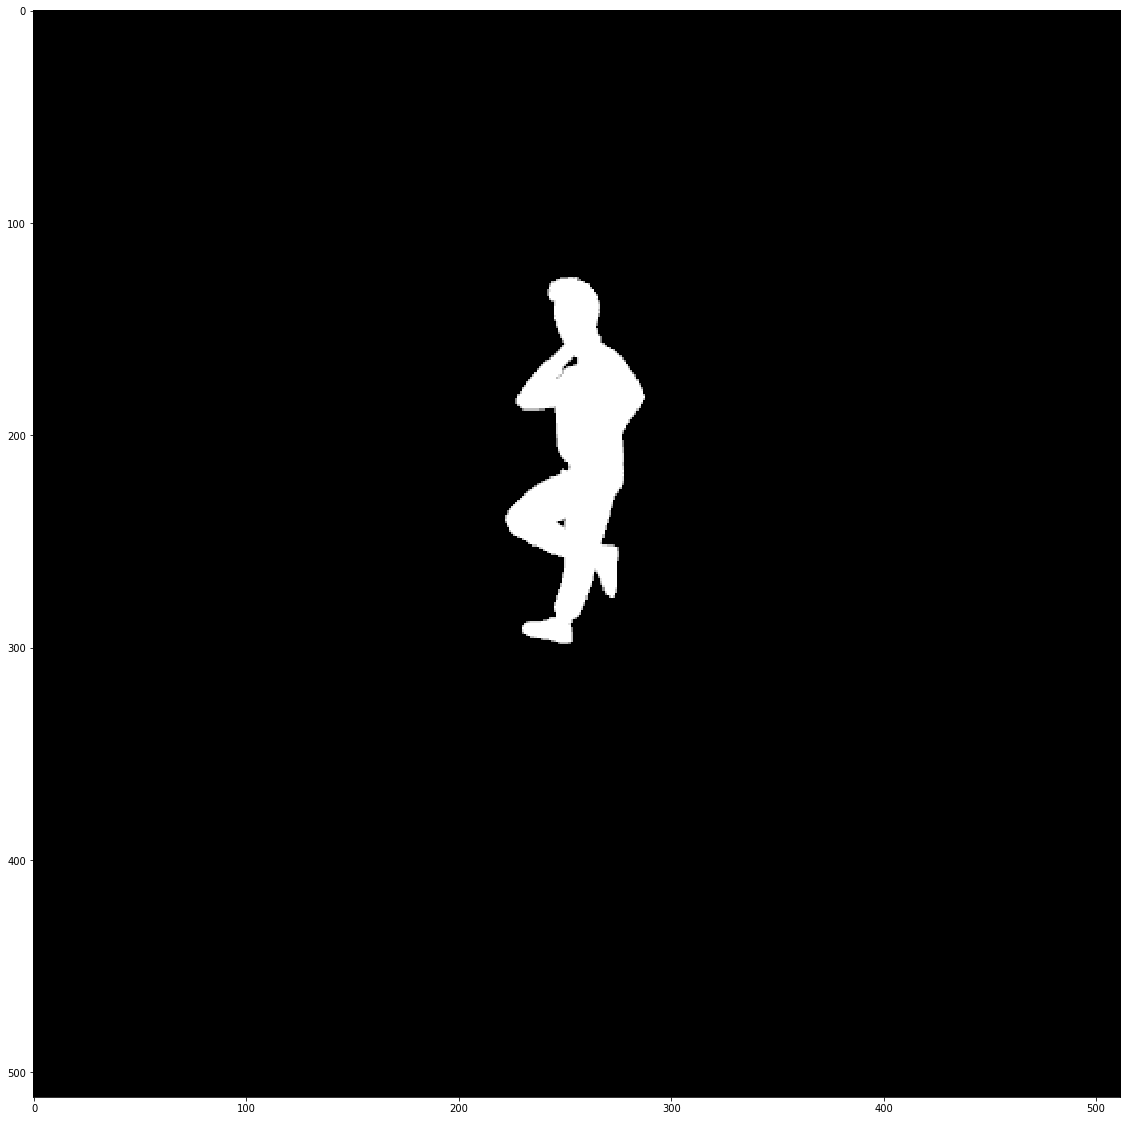

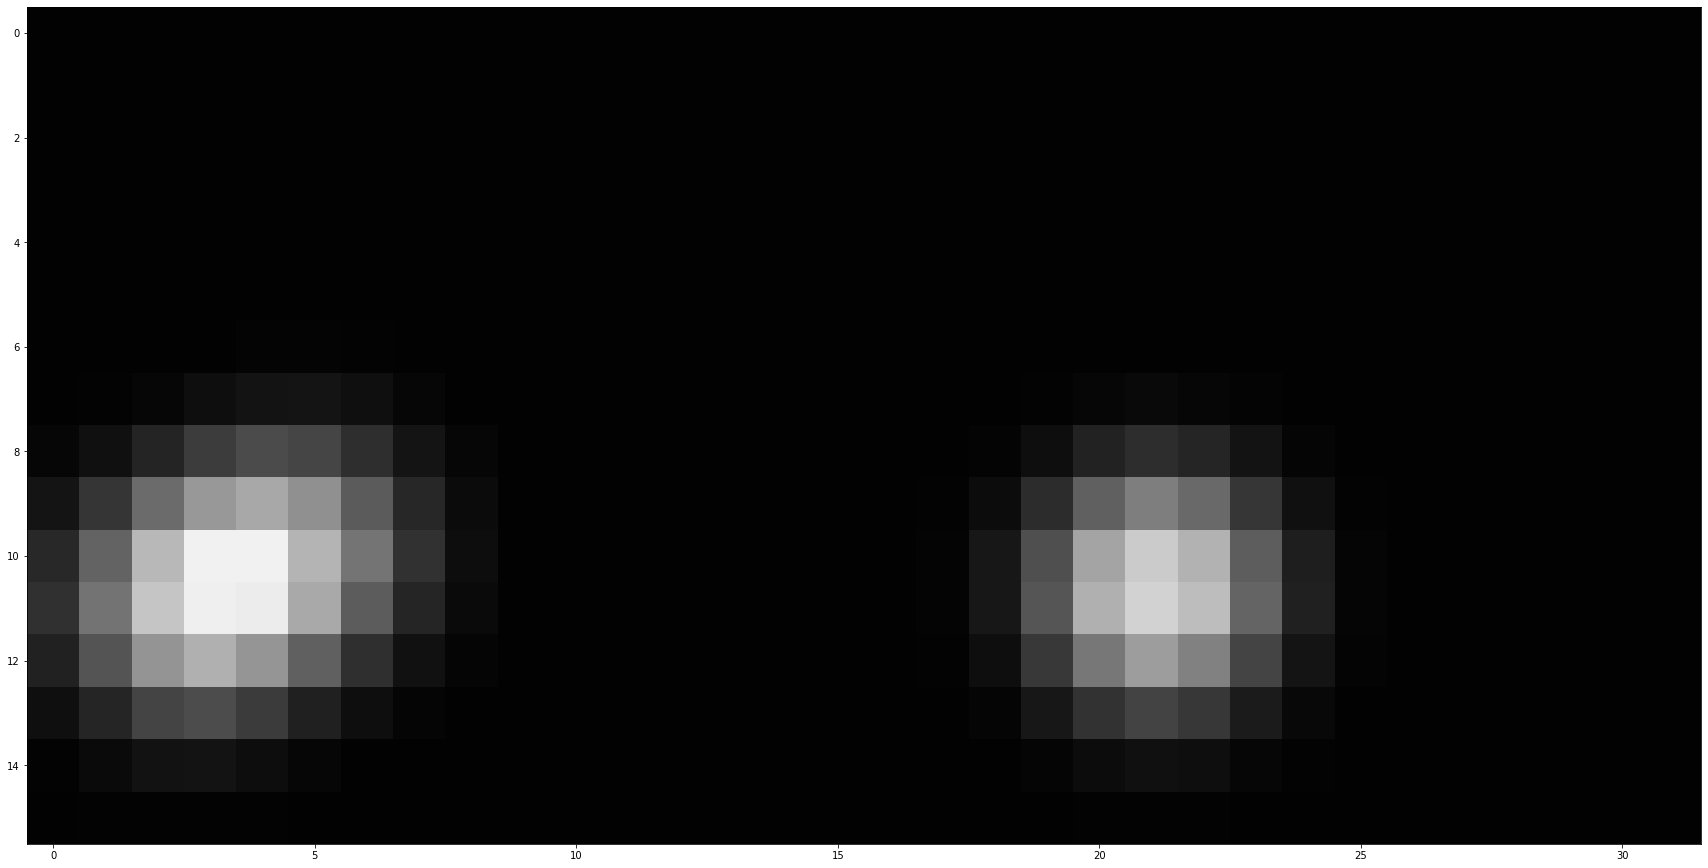

shadow min: 0.0, max: 1.0


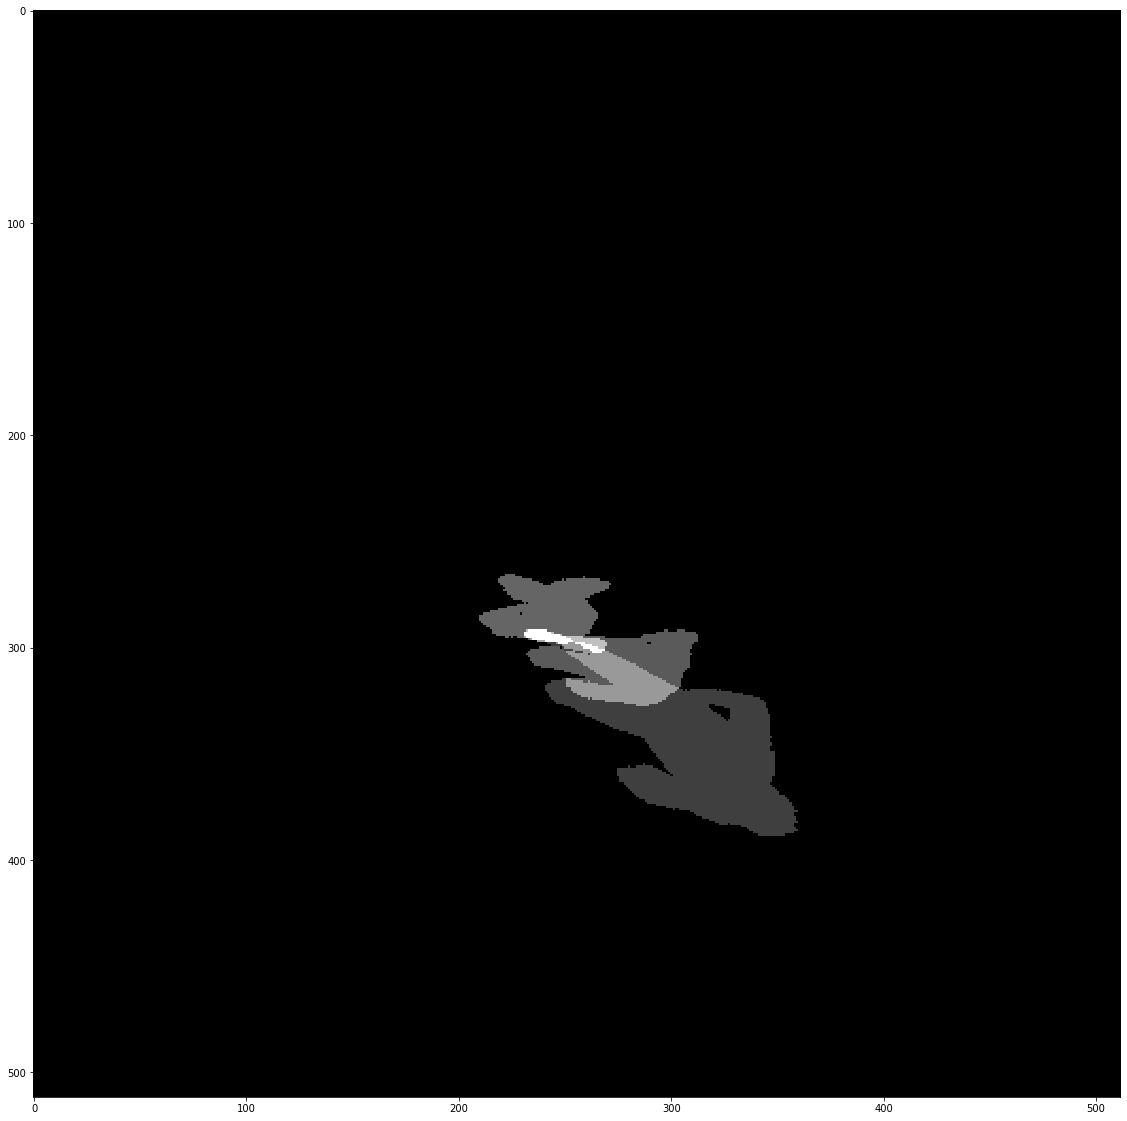

In [29]:
def vis_light(light_tensor):
    batch, c, h, w = light_tensor.shape
    tensor_ret = torch.zeros((batch * c, 1, h, w))
    counter = 0
    
    for i in range(batch):
        for j in range(c):
            tensor_ret[counter,:,:,:] = light_tensor[i,j,:,:]
            counter += 1
            
    return tensor_ret

def print_min_max(batch, comment):
    print('{} min: {}, max: {}'.format(comment, torch.min(batch), torch.max(batch)))

for i, (mask, light, shadow) in enumerate(dataloader):
    # print(torch.max(light))
    
    # concatenate human mask and shadow mask
    I_s, L_t, I_t = mask, light, shadow
    print_min_max(I_s, 'mask')
    print_min_max(L_t, 'light')
    print_min_max(I_t, 'shadow')
   
    # print('light size: ', light.size())
    
    print('Before light source min: {}, max: {}'.format(torch.min(L_t), torch.max(L_t)))
    
    print(L_t.shape)
    L_t = vis_light(L_t)
    print(L_t.shape)
    
    print('light source min: {}, max: {}'.format(torch.min(L_t), torch.max(L_t)))

    print(I_s.shape)
    show_batch(I_s)
    show_batch(L_t)
    
    I_t = I_t/torch.max(I_t)
    
    print('shadow min: {}, max: {}'.format(torch.min(I_t), torch.max(I_t)))
    b,c,h,w = I_t.shape
    show_batch(I_t)
    
    if i > 1:
        break
    
#     human_gt = I_t[:,0,:,:]
#     shadow_gt = I_t[:,1,:,:]
    
#     batch_size, c, h, w = I_t.size()
#     human_mask, shadow_mask = torch.zeros(batch_size, h, w, dtype= torch.float32), torch.zeros(batch_size, h, w, dtype= torch.float32)
#     human_mask[torch.where(human_gt !=0)] = 1
#     shadow_mask[torch.where(shadow_gt !=0)] = 1
    
# #     print(human_mask.size())
# #     print(shadow_mask.size())
    
#     show_batch(human_mask.view(batch_size, 1, h, w))
#     show_batch(shadow_mask.view(batch_size, 1, h, w))

In [ ]:
import seaborn 
import torch
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def to_numpy_img(t):
    t_np = t.numpy()
    t_np = np.transpose(t_np, (1,2,0))
    return t_np

test_tensor = torch.zeros(9,256, 256)
test = to_numpy_img(test_tensor)
test[128, 128, 0] = 1

test_ = gaussian_filter(test, sigma = 10)
seaborn.heatmap(test[:,:,0])
seaborn.heatmap(test_[:,:, 0])

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

# todo, vectorize this process
test_torch = torch.zeros(16,32)
for h in range(test_torch.size()[0]):
    test_torch[h,:] = abs(math.sin(h / 16.0 * 3.1415926)) + 0.001

test_np = test_torch.detach().cpu().numpy()

plt.figure()
plt.imshow(test_np,cmap='gray')light_np

In [ ]:
from ssn_submodule import Up
import torch

x1 = torch.randn(1,512, 16,16)
x2 = torch.randn(1,256, 32,32)

model = Up(512,256)
out = model(x1,x2)
print(out.size())

In [ ]:
data_file = '/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/ground_truth.txt'

with open(data_file,'r') as f:
    content = f.readlines()

lines = [c.strip() for c in content]
data_num = int(len(lines)/6)

def get_pos(pos_str):
    x = float(pos_str[1])
    y = float(pos_str[2])
    z = float(pos_str[3])
    return np.array([x,y,z])

def get_spherical(pos):
    x,y,z = pos
    alpha = np.arctan2(z,x)
    beta = np.arctan2(y, np.sqrt(x**2 + z**2))
    return alpha, beta

prefix_list, alpha_list, beta_list = [], [], []
for i in range(data_num):
    prefix_str = lines[6 * i + 0]
    human_pos_str = lines[6 * i + 3].split()
    light_pos_str = lines[6 * i + 4].split()
    human_pos = get_pos(human_pos_str)
    light_pos = get_pos(light_pos_str)
    
    light_dir = light_pos - human_pos
    light_dir_norm = light_dir/np.linalg.norm(light_dir, 2)
    alpha, beta = get_spherical(light_dir_norm)
    # print('alpha: {}, beta: {} \n'.format(alpha, beta))
    alpha_list.append(alpha + np.pi)
    beta_list.append(beta + np.pi)    
    prefix_list.append(prefix_str)
    
alpha_ary = np.array(alpha_list)
beta_ary = np.array(beta_list)

In [ ]:
from PIL import Image

def compute_IBL(alpha, beta):
    h, w = 256, 256
    IBL = np.zeros((h,w))
    
    two_pi = 2.0 * np.pi
    alpha_coord, beta_coord = int(w * alpha/two_pi), int(h * beta/two_pi)
    IBL[beta_coord, alpha_coord] = 1.0
    return IBL

def show_gau_light(ibl):
    light_np = gaussian_filter(ibl, sigma=3)/np.max(ibl)
    plt.figure(figsize=(10,6))
    plt.imshow(light_np)

for i in range(6400):
    ibl = compute_IBL(alpha_ary[i], beta_ary[i])
    show_gau_light(ibl)

    light_img = '{}/{}_light.png'.format('/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A',prefix_list[i])
    # light_img_np = np.array(Image.open(light_img).resize((32,32)))
    light_img_np = np.array(Image.open(light_img))
    show_gau_light(light_img_np)
    
    if i > 10:
        break